In [307]:
# Standard Libraries
import os
import zipfile

# Data Manipulation Libraries
import pandas as pd

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Progress Bar
from tqdm import tqdm


import cv2

# **Step 1: Load Data**

In [308]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

SEED =  42

In [309]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [310]:
# Define Disease Labels
disease_labels = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['class_name'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No finding'] = labels_df['class_name'].apply(lambda x: 1 if 'No finding' in x else 0)

    # Map image filenames to their full paths
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(image_path, 'train', f"{x}.dicom"))
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [311]:
labels_df = labels_df[labels_df['class_id'] != 14].reset_index(drop=True)
labels_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,Aortic enlargement,Atelectasis,...,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,No finding,Path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,0,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,0,0,...,0,0,0,0,0,1,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,0,0,...,0,0,0,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,0,0,...,0,0,1,0,0,0,0,0,0,/cluster/home/bjorneme/projects/Data/vinbigdat...


**Split Dataset by image_id**

In [312]:
# Split patients into training/validation and test sets
unique_patients = labels_df['image_id'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_df = labels_df[labels_df['image_id'].isin(train_val_patients)].reset_index(drop=True)
val_df = labels_df[labels_df['image_id'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_df.shape[0]}")
print(f"Val size: {val_df.shape[0]}")

Train size: 28957
Val size: 7139


# **Step 4: Data Preprocessing**

In [313]:
import pydicom
import numpy as np
from PIL import Image

def load_dicom_image(path):
    dicom = pydicom.dcmread(path)
    image = dicom.pixel_array.astype(np.float32)
    # Optionally normalize or window the image for better contrast
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # normalize to [0,1]
    image = Image.fromarray((image * 255).astype(np.uint8)).convert("RGB")
    return image

**Define Dataset for VinDr-CXR**

In [314]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VinDrCXRDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['Path']
        image = load_dicom_image(img_path)
        # Convert PIL image to numpy array
        image_np = np.array(image)
        
        bbox = [row['x_min'], row['y_min'], row['x_max'], row['y_max']]
        label = row['class_id']
        
        target = {
            'boxes': torch.tensor([bbox], dtype=torch.float32),
            'labels': torch.tensor([label], dtype=torch.int64)
        }
        
        if self.transforms:
            transformed = self.transforms(image=image_np, bboxes=[bbox], labels=[label])
            image = transformed['image']
            bbox = transformed['bboxes'][0]
            label = transformed['labels'][0]
            target = {
                'boxes': torch.tensor([bbox], dtype=torch.float32),
                'labels': torch.tensor([label], dtype=torch.int64)
            }
        
        return image, target


**Define Data Transformations**

In [315]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


**Create Datasets**

In [316]:
train_dataset = VinDrCXRDataset(train_df, transforms=train_transforms)
val_dataset = VinDrCXRDataset(val_df, transforms=val_transforms)

**Create DataLoaders**

In [317]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=32)

**Plot one Sample**

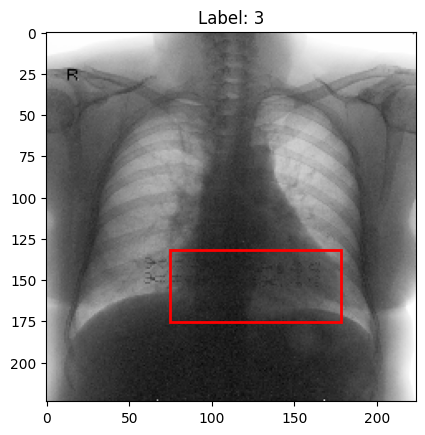

In [318]:
def plot_sample(dataset, index=0):
    image, target = dataset[index]
    # Convert tensor image to numpy array and denormalize
    image_np = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    
    # Plot bounding box
    boxes = target['boxes'].numpy()
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(f"Label: {target['labels'].item()}")
    plt.show()

# Plot a sample from the training dataset
plot_sample(train_dataset, index=0)

# **Step 7: Build the Model**

In [319]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

**Define Loss Function, Optimizer and Scheduler**

In [320]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Optimizer and Learning Rate Scheduler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# **Step 8: Train the Model**

In [321]:
# TODO

Epoch 1/3:   0%|          | 0/905 [00:00<?, ?it/s]

# **Step 9: Evaluate the Model**

In [ ]:
# TODO

# Use mAP0.5 and mAP0.5:0.95